# Generative Adversarial Network
Trained on Mnist Dataset to generate new handwritten digits.

In [74]:
%matplotlib inline

import pickle as pkl
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [75]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data')

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


### Model Inputs
2 Inputs: inputs_real for the discriminator, inputs_z for the generator

In [76]:
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None, real_dim), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    
    return inputs_real, inputs_z


### Generator
Function to create the generator, using the tanh over the output and a LeakyRelu over the hidden_layer.
tf.variable_scope to reuse the same learned parameters of the generator to produce different images.

In [77]:
def generator(z, out_dim, n_units=128, reuse=False, alpha=0.01):
    with tf.variable_scope('generator', reuse=reuse):
        
        h1 = tf.layers.dense(z, n_units, activation=None)
 
        h1 = tf.maximum(alpha * h1, h1)
        
    
        logits = tf.layers.dense(h1, out_dim, activation=None)
        gen_out = tf.tanh(logits)
        
        return gen_out    

### Discriminator
(sigmoid replace tanh)

In [78]:
def discriminator(x, n_units=128, reuse=False, alpha=0.01):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Hidden layer
        h1 = tf.layers.dense(x, n_units, activation=None)
        # Leaky ReLU
        h1 = tf.maximum(alpha * h1, h1)
        
        logits = tf.layers.dense(h1, 1, activation=None)
        d_out = tf.sigmoid(logits)
        
        return d_out, logits    

### Hyperparameters

In [79]:
#input to the discriminator and output of the generator - dimension of mnist digits
input_size = 784
z_size = 100
g_hidden_size = 128
d_hidden_size = 128
alpha = 0.01
smooth = 0.1

### Building the Network

with two discriminator, 1 for real input data, 1 for input from the generator.

In [80]:
tf.reset_default_graph()

input_real, input_z = model_inputs(input_size, z_size)

g_model = generator(input_z, input_size, n_units=g_hidden_size, alpha=alpha)
d_model_real, d_logits_real = discriminator(input_real, n_units=d_hidden_size, alpha=alpha)
d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, n_units=d_hidden_size, alpha=alpha)


### Losses
Discriminator_fake loss is proportional to the divergence between logits_fake_d and logits_real_d labeled with 0, since it would choose right every time sees a fake and output 1! Same reasoning behind d_real_loss and genereator_loss.
So, d_real_loss is proportional to the divergence between d_real_logits and d_real_logits labeled with ones, since it would choose right every time sees a real image and output 1!

In [81]:
d_loss_real = tf.reduce_mean(
                  tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                          labels=tf.ones_like(d_logits_real) * (1 - smooth)))
d_loss_fake = tf.reduce_mean(
                  tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                          labels=tf.zeros_like(d_logits_real)))
d_loss = d_loss_real + d_loss_fake

g_loss = tf.reduce_mean(
             tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                     labels=tf.ones_like(d_logits_fake)))

### Optimizer

In [82]:
learning_rate = 0.002


t_vars = tf.trainable_variables()
g_vars = [var for var in t_vars if var.name.startswith('generator')]
d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

d_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)
g_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)


### Training

In [83]:
batch_size = 100
epochs = 100
samples = []
losses = []

saver = tf.train.Saver(var_list=g_vars)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        for ii in range(mnist.train.num_examples//batch_size):
            batch = mnist.train.next_batch(batch_size)
                    
            batch_images = batch[0].reshape((batch_size, 784))
            batch_images = batch_images*2 - 1
            
            
            batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            
            
            _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
            _ = sess.run(g_train_opt, feed_dict={input_z: batch_z})
        
        train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
        train_loss_g = g_loss.eval({input_z: batch_z})
            
        print("Epoch {}/{}...".format(e+1, epochs),
              "Discriminator Loss: {:.4f}...".format(train_loss_d),
              "Generator Loss: {:.4f}".format(train_loss_g))    
        
        losses.append((train_loss_d, train_loss_g))
        
        
        sample_z = np.random.uniform(-1, 1, size=(16, z_size))
        gen_samples = sess.run(
                       generator(input_z, input_size, reuse=True),
                       feed_dict={input_z: sample_z})
        samples.append(gen_samples)
        saver.save(sess, './checkpoints/generator.ckpt')

with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

Epoch 1/100... Discriminator Loss: 0.3917... Generator Loss: 3.0740
Epoch 2/100... Discriminator Loss: 0.4949... Generator Loss: 3.1782
Epoch 3/100... Discriminator Loss: 1.4159... Generator Loss: 4.2887
Epoch 4/100... Discriminator Loss: 1.1231... Generator Loss: 1.4862
Epoch 5/100... Discriminator Loss: 1.1798... Generator Loss: 3.2290
Epoch 6/100... Discriminator Loss: 0.9941... Generator Loss: 2.1828
Epoch 7/100... Discriminator Loss: 1.6000... Generator Loss: 1.3712
Epoch 8/100... Discriminator Loss: 2.3382... Generator Loss: 1.0272
Epoch 9/100... Discriminator Loss: 1.6419... Generator Loss: 2.4611
Epoch 10/100... Discriminator Loss: 1.2563... Generator Loss: 1.4427
Epoch 11/100... Discriminator Loss: 4.0173... Generator Loss: 1.0796
Epoch 12/100... Discriminator Loss: 1.3798... Generator Loss: 1.6880
Epoch 13/100... Discriminator Loss: 0.9535... Generator Loss: 1.5986
Epoch 14/100... Discriminator Loss: 2.0032... Generator Loss: 1.2826
Epoch 15/100... Discriminator Loss: 0.8640.

### Plotting the training Loss

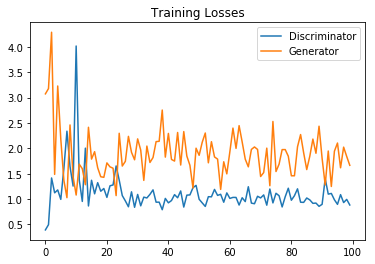

In [84]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title('Training Losses')
plt.legend()

In [98]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')
    
    return fig, axes

In [99]:
with open('./train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

In [100]:
#Samples from the final training epoch: just samples, they are not representative.

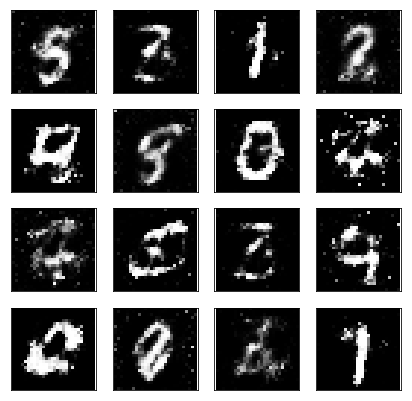

In [101]:
_ = view_samples(-1, samples)

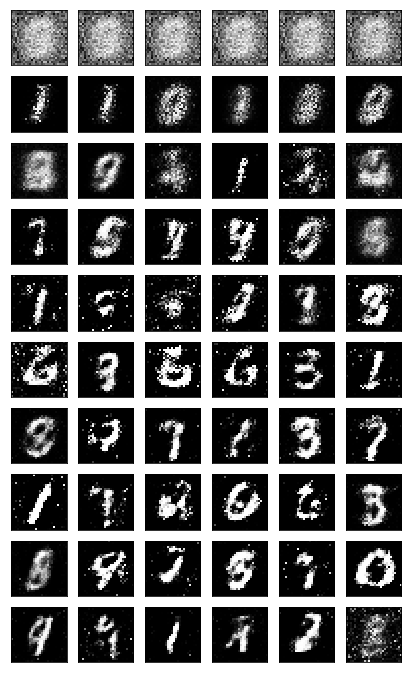

In [102]:
rows, cols = 10, 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

### Sampling from the Generator

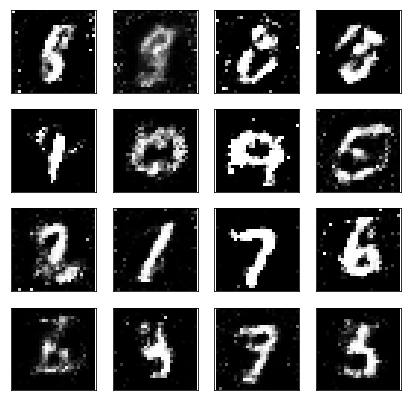

In [104]:
saver = tf.train.Saver(var_list=g_vars)
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    sample_z = np.random.uniform(-1, 1, size=(16, z_size))
    generator_sample = sess.run(generator(input_z, input_size, reuse=True), feed_dict={input_z:sample_z})
_= view_samples(0, [generator_sample])    